# **Bengaluru Housing Price Prediction**


**Get the Dataset**

Here we're using the public Bangalore house data (e.g. Bengaluru_House_Data.csv) with ~13 000 rows and typical features: location, size (e.g. “2 BHK”), total_sqft, bath, balcony, and price (in lakhs)

In [1]:
# importing dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Load the data

import kagglehub

# Download latest version
path = kagglehub.dataset_download("amitabhajoy/bengaluru-house-price-data")

print("Path to dataset files:", path)

100%|██████████| 195k/195k [00:00<00:00, 710kB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/amitabhajoy/bengaluru-house-price-data/versions/2


In [3]:
# Load the CSV
df = pd.read_csv('/root/.cache/kagglehub/datasets/amitabhajoy/bengaluru-house-price-data/versions/2/Bengaluru_House_Data.csv')

# View basic info
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [4]:
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [5]:
# Shape and columns
print("Shape:", df.shape)
print("\nColumns:", df.columns)

Shape: (13320, 9)

Columns: Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')


In [6]:
for columns in df.columns:
    print(df[columns].value_counts())
    print("****" * 10)

area_type
Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: count, dtype: int64
****************************************
availability
Ready To Move    10581
18-Dec             307
18-May             295
18-Apr             271
18-Aug             200
                 ...  
16-Oct               1
17-Jan               1
16-Nov               1
16-Jan               1
14-Jul               1
Name: count, Length: 81, dtype: int64
****************************************
location
Whitefield                 540
Sarjapur  Road             399
Electronic City            302
Kanakpura Road             273
Thanisandra                234
                          ... 
Park View Layout             1
Xavier Layout                1
Air View Colony              1
akshaya nagar t c palya      1
mvj engineering college      1
Name: count, Length: 1305, dtype: int64
****************************************
size
2 BHK         5199
3 BHK  

# **EDA**

In [7]:
# Convert 'size' to numeric (e.g., '2 BHK' → 2)
# Drop rows with missing 'size' values first
df.dropna(subset=['size'], inplace=True)
df['bhk'] = df['size'].apply(lambda x: int(x.split(' ')[0]))

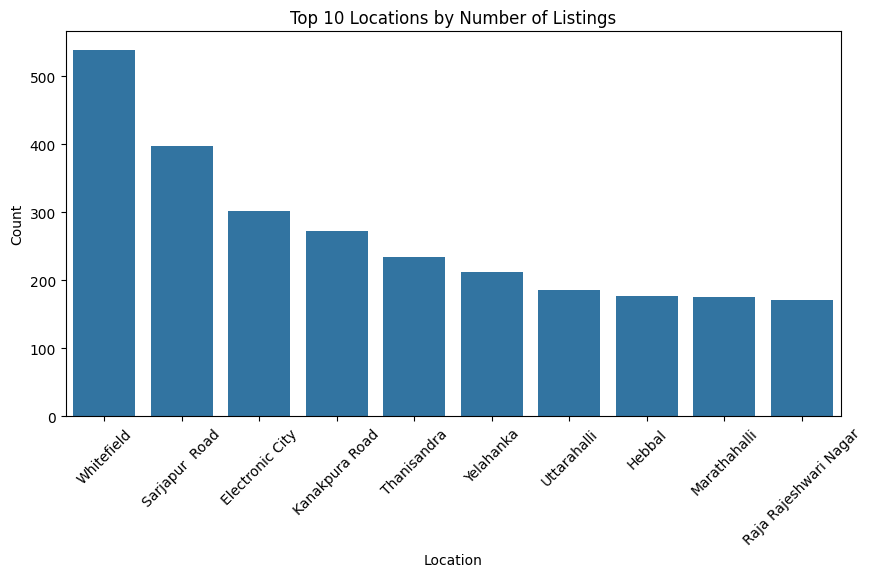

In [8]:
# Top 10 locations with most listings
top_locations = df['location'].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_locations.index, y=top_locations.values)
plt.xticks(rotation=45)
plt.title('Top 10 Locations by Number of Listings')
plt.xlabel('Location')
plt.ylabel('Count')
plt.show()

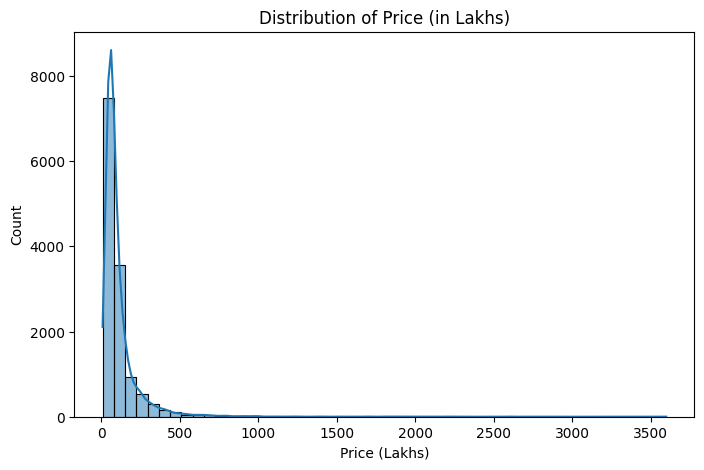

In [9]:
#  Distribution of price
plt.figure(figsize=(8, 5))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Distribution of Price (in Lakhs)')
plt.xlabel('Price (Lakhs)')
plt.ylabel('Count')
plt.show()

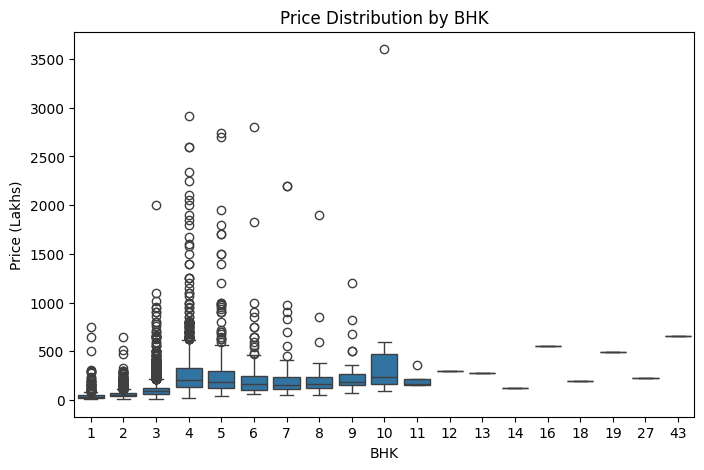

In [10]:
# Boxplot: price vs BHK
plt.figure(figsize=(8, 5))
sns.boxplot(x='bhk', y='price', data=df)
plt.title('Price Distribution by BHK')
plt.xlabel('BHK')
plt.ylabel('Price (Lakhs)')
plt.show()


In [11]:
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,bhk
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07,2
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00,4
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00,3
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00,3
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00,2


In [12]:
df.shape

(13304, 10)

# **Feature Engineering and Data Cleaning**

In [13]:
# Convert 'total_sqft' to a single numeric value
def convert_sqft_to_num(x):
    try:
        x = str(x)
        tokens = x.split('-')
        if len(tokens) == 2:
            return (float(tokens[0]) + float(tokens[1])) / 2
        return float(x)
    except:
        return None

df['total_sqft'] = df['total_sqft'].apply(convert_sqft_to_num)

# Drop rows with invalid or null 'total_sqft'
df = df.dropna(subset=['total_sqft'])

print("After sqft conversion:", df.shape)

After sqft conversion: (13258, 10)


# **Calculating Price per Square Foot**

In [14]:
# Add new column: price per square foot
df['price_per_sqft'] = df['price'] * 100000 / df['total_sqft']

# **Cleaning and Grouping Location Data**

In [15]:
# Clean 'location' text
df['location'] = df['location'].apply(lambda x: str(x).strip())

# Group rare locations as 'other'
location_counts = df['location'].value_counts()
rare_locations = location_counts[location_counts <= 10].index
df['location'] = df['location'].apply(lambda x: 'other' if x in rare_locations else x)

print("Unique locations:", len(df['location'].unique()))

Unique locations: 241


# **Removing Unrealistically Small BHK Configurations**

In [16]:
# Remove rows where total_sqft per BHK is less than 300
df = df[df['total_sqft'] / df['bhk'] >= 300]

print("After removing low sqft per BHK:", df.shape)


After removing low sqft per BHK: (12514, 11)


# **Removing Location-Wise Price per Sqft Outliers**

In [17]:
# This function removes price_per_sqft outliers location-wise
def remove_pps_outliers(df):
    cleaned_df = pd.DataFrame()  # Empty DataFrame to store clean data

    # Group data by each location
    for location, group in df.groupby('location'):
        mean = group['price_per_sqft'].mean()
        std = group['price_per_sqft'].std()

        # Keep only rows where price_per_sqft is within one std deviation from mean
        filtered = group[(group['price_per_sqft'] > (mean - std)) &
                         (group['price_per_sqft'] <= (mean + std))]

        cleaned_df = pd.concat([cleaned_df, filtered], ignore_index=True)

    return cleaned_df

# Apply the function to clean the dataset
df = remove_pps_outliers(df)

print("✅ After removing price_per_sqft outliers:", df.shape)


✅ After removing price_per_sqft outliers: (10338, 11)


# **Removing BHK-Based Pricing Outliers**

In [18]:
def remove_bhk_outliers(df):
  indices_to_remove = []

  for location, location_df in df.groupby('location'):
        # Create a dictionary to store price stats for each BHK level
        bhk_price_stats = {}

        # Loop through each BHK group in that location
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_price_stats[bhk] = {
                'mean_price': bhk_df['price_per_sqft'].mean(),
                'std_dev': bhk_df['price_per_sqft'].std(),
                'count': bhk_df.shape[0]
            }

        # Now check if a higher BHK is priced less than the lower BHK's average
        for bhk, bhk_df in location_df.groupby('bhk'):
            lower_bhk_stats = bhk_price_stats.get(bhk - 1)
            if lower_bhk_stats and lower_bhk_stats['count'] > 5:
                # If this BHK is priced less than the previous BHK's average → outlier
                bad_bhk = bhk_df[bhk_df['price_per_sqft'] < lower_bhk_stats['mean_price']]
                indices_to_remove.extend(bad_bhk.index)

                # Drop all detected outliers
                return df.drop(indices_to_remove, axis='index')

# Apply the function
df = remove_bhk_outliers(df)

print("✅ After removing BHK outliers:", df.shape)


✅ After removing BHK outliers: (10337, 11)


# **Removing Unrealistic Bathroom Counts**

In [19]:
# Keep rows where number of bathrooms is reasonable
df = df[df['bath'] < df['bhk'] + 2]

print("After removing bathroom outliers:", df.shape)

After removing bathroom outliers: (10191, 11)


# Dropping Unnecessary Columns for **Modeling**

In [20]:
# Drop unused columns
df_model = df.drop(['size', 'price_per_sqft'], axis=1)
df_model.head()

,area_type,availability,location,society,total_sqft,bath,balcony,price,bhk
0,Super built-up Area,20-May,1st Block Jayanagar,NaN,2850.0,4.0,1.0,428.0,4
1,Super built-up Area,18-Jun,1st Block Jayanagar,NaN,1630.0,3.0,2.0,194.0,3
2,Super built-up Area,Ready To Move,1st Block Jayanagar,NaN,1875.0,2.0,3.0,235.0,3
3,Built-up Area,15-Dec,1st Block Jayanagar,Bhsic C,1200.0,2.0,0.0,130.0,3
4,Super built-up Area,18-Jun,1st Block Jayanagar,NaN,1235.0,2.0,2.0,148.0,2


In [21]:
df['location'].unique()

array(['1st Block Jayanagar', '1st Phase JP Nagar',
       '2nd Phase Judicial Layout', '2nd Stage Nagarbhavi',
       '5th Block Hbr Layout', '5th Phase JP Nagar', '6th Phase JP Nagar',
       '7th Phase JP Nagar', '8th Phase JP Nagar', '9th Phase JP Nagar',
       'AECS Layout', 'Abbigere', 'Akshaya Nagar', 'Ambalipura',
       'Ambedkar Nagar', 'Amruthahalli', 'Anandapura', 'Ananth Nagar',
       'Anekal', 'Anjanapura', 'Ardendale', 'Arekere', 'Attibele',
       'BEML Layout', 'BTM 2nd Stage', 'BTM Layout', 'Babusapalaya',
       'Badavala Nagar', 'Balagere', 'Banashankari',
       'Banashankari Stage II', 'Banashankari Stage III',
       'Banashankari Stage V', 'Banashankari Stage VI', 'Banaswadi',
       'Banjara Layout', 'Bannerghatta', 'Bannerghatta Road',
       'Basavangudi', 'Basaveshwara Nagar', 'Battarahalli', 'Begur',
       'Begur Road', 'Bellandur', 'Benson Town', 'Bharathi Nagar',
       'Bhoganhalli', 'Billekahalli', 'Binny Pete', 'Bisuvanahalli',
       'Bommanahalli'

In [22]:
# Create dummy variables (one-hot encoding) for location
dummies = pd.get_dummies(df_model['location'], dtype=int)
df_model = pd.concat([df_model.drop('location', axis=1), dummies.drop('other', axis=1)], axis=1)

print("Final shape after encoding:", df_model.shape)

Final shape after encoding: (10191, 248)


In [23]:
#Split features and label
X = df_model.drop('price', axis=1)
y = df_model['price']

# Drop availability and society columns
X = X.drop(['availability', 'society'], axis=1)

# Impute missing values in 'balcony' with the median
X['balcony'] = X['balcony'].fillna(X['balcony'].median())

# One-hot encode area_type
X = pd.get_dummies(X, columns=['area_type'], drop_first=True, dtype=int)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (8152, 247)
X_test shape: (2039, 247)


# **Linear Regression**

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Train a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Evaluate on test set
y_pred = lr_model.predict(X_test)
lr_r2 = r2_score(y_test, y_pred)
lr_mse = mean_squared_error(y_test, y_pred)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(y_test, y_pred)

print("Linear Regression R² Score:", round(lr_r2, 3))
print("Linear Regression MSE:", round(lr_mse, 3))
print("Linear Regression RMSE:", round(lr_rmse, 3))
print("Linear Regression MAE:", round(lr_mae, 3))

Linear Regression R² Score: 0.765
Linear Regression MSE: 2071.957
Linear Regression RMSE: 45.519
Linear Regression MAE: 20.144


# **RandomForest Regressor**

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate on test set
y_pred_rf = rf_model.predict(X_test)
rf_r2 = r2_score(y_test, y_pred_rf)
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test, y_pred_rf)

print("Random Forest R² Score:", round(rf_r2, 3))
print("Random Forest MSE:", round(rf_mse, 3))
print("Random Forest RMSE:", round(rf_rmse, 3))
print("Random Forest MAE:", round(rf_mae, 3))

Random Forest R² Score: 0.7
Random Forest MSE: 2647.101
Random Forest RMSE: 51.45
Random Forest MAE: 19.397


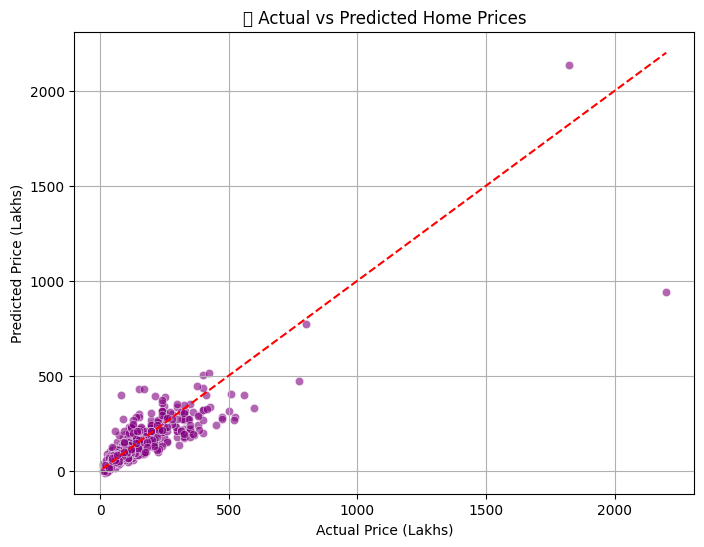

In [26]:
#Scatter plot of Actual vs Predicted

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')  # Diagonal line
plt.xlabel('Actual Price (Lakhs)')
plt.ylabel('Predicted Price (Lakhs)')
plt.title('🔍 Actual vs Predicted Home Prices')
plt.grid(True)
plt.show()